In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# TD Control with SARSA($\lambda$)

Is similar to SARSA but instead of using the default TD learning it uses TD($\lambda$) so that we can control how much we would like to look into the future (parameter $\lambda$)


## Forward view SARSA($\lambda$)
It looks forward in time and does thereby not work online. That means, we can update the Q only after finishing an episode?! 
The algorithm works similar to SARSA with:

$$
Q(S_t,A_t) \gets Q(S_t,A_t) + \alpha (q_t^{\lambda} - Q(S_t,A_t))
$$

and 
$$
q_t^{\lambda} = (1-\lambda) \cdot \sum_{n=1}^{\inf} \lambda^{n-1} q^{(n)}_t
$$

we can make this learning online by using eligibility traces!

## Backward view SARSA($\lambda$)

SARSA has one eligibility trac for each state-action pair:

$$
E_0(s,a) = 0
$$
$$
E_t(s,a) = \gamma \lambda \cdot E_{t-1}(s,a) +1(S_t = a, A_t = a) 
$$

This trace tells you how much credit or blame you should assign to every action you took from every state __at the end of an episode__. That is, which of the state and actions are responsible for the reward at the end.

If you are actually at state $S_t$ and perform action $A_t$ at time t, you update the eligibility trace for state $s$ and action $a$ (+1).
We decay the eligibility trace for __all__ state action pairs in each time step.

TD error is defined as usual:
$$
\delta_t = R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})
$$
and
$$
Q(s,a) \gets Q(s,a) + \alpha \cdot \delta_t \cdot E_t(s,a) 
$$

__SARSA backward view algorithm:__
* Initialize Q(s,a) arbitrarily
* Repeat (for each episode):
    * $E(s,a) = 0$ for all s,a
    * Initialize S,A
    * Repeat (for each step of episode):
        * Take action A, observer R,S'
        * Choose A' from S' using policy derived from Q (e.g. $\epsilon$-greedy)
        * $\delta \gets R + \gamma (Q(S',A') - Q(S,A)$
        * $E(S,A) \gets E(S,A) + 1$
        * __For all s and a__ :
            * $ Q(s,a) \gets Q(s,a) + \alpha \delta E(s,a)$
            * $ E(s,a) \gets \gamma \lambda E(s,a)$
        * $S \gets S'$
        * $A \gets A'$
    * until S is terminal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotting
import random
from operator import itemgetter

plotting.set_layout(drawing_size=15)


## Define the Environment

* In every state (except goal state) a moment has a cost of -1
* In a goal state, thers is no cost for moving
* If the agent is in a goal state, do not execute any moevement


In [2]:

class environment():
    """ This class defines all the necessary properties of the environment. 
        For now, the environment is a nxn rectangular grid"""
    
    def __init__(self,n_x=10,n_y=7,s_start=(0,3),s_goals=[(7,3)]):
        """ n_x: defines the width of the environment
            n_y: defines the height of the environment
            s_start: defines the starting position of the agent (x-,y-position)
            """ 
        
        # Define the grid
        self.n_x = n_x
        self.n_y = n_y
        
        
        # Agent position
        self.x_agent = s_start[0]
        self.y_agent = s_start[1]
        # Agent actions
        self.actions = [0,1,2,3] # equals 'n','e','s','w'
        
        # Define rewards
        self.rewards = np.ones((n_x,n_y)) * (-1)
        # Define goal states
        self.s_goals = s_goals
        for g_i,g in enumerate(s_goals):
            self.rewards[g] = 0
            
        # Define the perturbations (wind)
        # first tuple entry gives the x location. second entry the strength at that location
        self.wind = [(3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1)]
            
    
    def reset_agent(self, s_start):
        # Resets the the agent's position to the original starting position
        self.x_agent = s_start[0]
        self.y_agent = s_start[1]
            
    
    
    def move(self,a=None,state=None):
        """ Moves the agent from its current state to the next state given action a
            and returns a reward for that movement and the new state
            a: is the action            
        """

        assert(a in self.actions)
        
       
        x = self.x_agent
        y = self.y_agent
              
        # execute movement. For now, the environment is deterministic
        if a == 0:
            x += 1
        if a == 1:
            x -= 1
        if a == 2:
            y -= 1
        if a == 3:
            y += 1
            
        # Simulate the perturbations (wind in y-direction)
        # For now they are fixed as shown in the lecture 
        # check if the agent is on a windy spot
        if x in [i[0] for i in self.wind]:
            # move the agent in the direction (upwards is negative)
            y -= [i[1] for i in self.wind if x==i[0]][0]
                
        
        # If agent is in a goal state, do not move anymore and end the episde
        if (x, y) in self.s_goals:
            return x,y,self.get_reward(x,y),True
        
        
        # make sure to stay in the environment. if an acion moves the agent outside, just remain in current state
        x = max(min(x,self.n_x-1),0)
        y = max(min(y,self.n_y-1),0)
        
        # set new state and return rewards of new state
        self.x_agent = x
        self.y_agent = y
        return x,y, self.get_reward(x,y), False
    
    def get_reward(self, x,y):
        # Returns the reward for a given state
        return self.rewards[x,y]
        

## Define the Agent

In [80]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self,n_x=10,n_y=7,pos_start=(0,3),epsilon=1.0):
        """ n_x: defines the width of the environment
            n_y: defones the height of the environment
            pos_start: defines the starting position of the agent (x-,y-position)
            gamma: the discount factor            """ 
        
        
        # Store the discount factor 
        self.gamma = 1
        # Store the update rate
        self.alpha = 0.6
        # Store the epsilon paramter
        self.epsilon = epsilon
        # Store lambda parameter
        self.lamb = 0.6

        
        # Store size of environment
        self.n_x = n_x
        self.n_y = n_y
                
        # Agent actions
        self.actions = [0,1,2,3] # equals 'n','e','s','w'
        
        # Store the action value function for each state and action
        self.q = np.zeros((n_x,n_y,len(self.actions)))
        
        # Store the eligibility trace
        self.E = np.zeros((n_x,n_y,len(self.actions)))
        
    def set_epsilon(self,epsilon):
        # set the epsilon parameter
        # Needed to turn off epsilon greedy behavior
        self.epsilon = epsilon
        
    def reset_eligibility(self):
        # Resets the eligibility trace. Should be done after each episde
        self.E = np.zeros((self.n_x,self.n_y,len(self.actions)))
        

    def greedy_move(self,s, k_episode):
        # given a state return the next move according to epsilon greedy algorithm
        
        # find optimal action a^*
        q_a = []
        for i_a,a in enumerate(self.actions):
            # get value for action state pair
            v = self.q[s[0],s[1],a]
            q_a.append((v,a))
    
        # get action with maximal value
        a_max = max(q_a,key=itemgetter(0))[1]
        
        # with probabiliyt 1-eps execute the best action otherwise choose other action
        if np.random.rand() <= (1-self.epsilon):
            a = a_max
        else:
            # choose an action randomly
            a = random.sample(self.actions,1)[0]
        
        # decrement epsilon
        if self.epsilon != 0.0:
            self.epsilon = 1/(k_episode)
        
        return a
                          
    
    def policy_evaluation(self,state, reward, action, new_state, new_action):
        # Update Q(s,a) incrementally 

        # Get the action-value function for that state
        Q_s = self.q[state[0],state[1],action]
        
        # cacluate TD error
        delta = reward + self.gamma * self.q[new_state[0],new_state[1], new_action] -  Q_s 
        
        # increment eligbility trace
        self.E[state[0],state[1],action] += 1
        
        # walk over all states and actions and upadte Q and E
        # This could probably be fasten up by recording which state we visited and only updating them
        for i in range(self.n_x):
            for j in range(self.n_y):
                for k in range(len(self.actions)):
                    self.q[i,j,k] += self.alpha * delta * self.E[i,j,k]
                    self.E[i,j,k] *= self.gamma * self.lamb

In [81]:
# Set up the environmental variables

# environment size
n_x = 10
n_y = 7

# start position of agent
start_state = [0,3]

# initialize everything
env = environment(n_x=n_x, n_y=n_y, s_start=start_state)
agent = agents(n_x=n_x, n_y=n_y, pos_start=start_state)

# number of episodes to run
k = 170

# counts the needed time steps to reach the goal per episode
ts_per_episode = np.zeros(k)

# run for k epsiodes:
for ep in range(k):
    # set the agent back to the starting position
    env.reset_agent(start_state)
    # reset eligibility trace
    agent.reset_eligibility()
    goal_reached = False
    # reset counter
    i = 0
    # set the initial state
    s = start_state
    # choose initial action of the agent
    a = agent.greedy_move(s,1)
    # run the policy iteration until goal is reached
    while not goal_reached:
        # execute movement
        x,y,reward, goal_reached = env.move(a)
        
        # set s'
        s_prime = [x,y]
        
        # choose the next move a' according to e-greedy
        a_prime = agent.greedy_move(s_prime,i+1)

        # do TD learning based on states, actions and rewards
        agent.policy_evaluation(s,reward,a,s_prime,a_prime)

        # set new states and actions
        s = s_prime
        a = a_prime
        i += 1
        
    # save the neede time steps
    ts_per_episode[ep] = i        
    

    


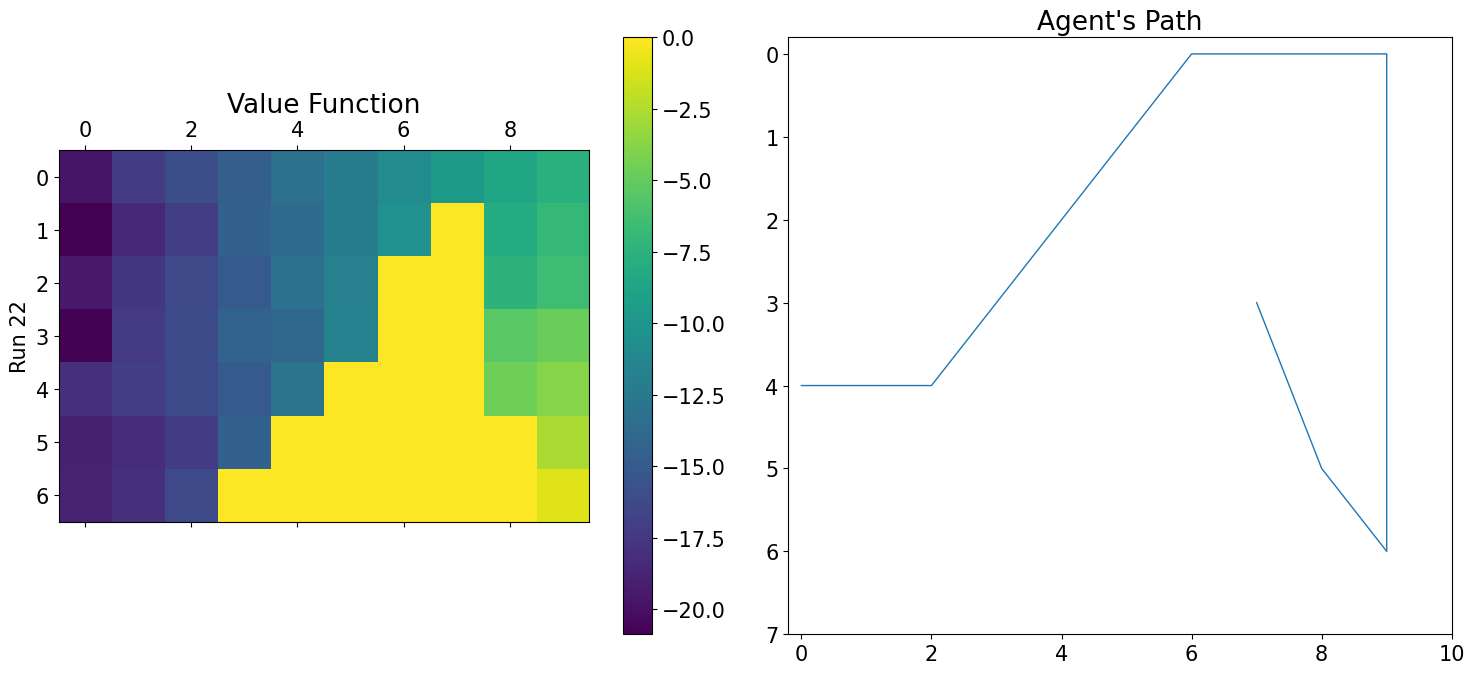

In [82]:
# plot the results
fig =plt.figure(figsize=(15,7))
axes = fig.subplots(1,2,squeeze=False)
ax = axes[0,0]
c = ax.matshow(agent.q.max(2).T)
ax.set_ylabel('Run {0:}'.format(i))
ax.set_title('Value Function')
plt.colorbar(c, ax = ax)




#### Plot best policy

ax = axes[0,1]
env_ = environment(n_x=n_x, n_y=n_y, s_start=start_state)
# set epsilon to zero so that we follow a greedy policy
agent.set_epsilon(0.0)

goal_reached = False

x_s =[]
y_s =[]

s = start_state
while not goal_reached:
    a = agent.greedy_move(s,1)
    x,y,reward, goal_reached = env_.move(a)
    x_s.append(x)
    y_s.append(y)
    s = [x,y]


    
ax.plot(x_s,y_s)

ax.set_xlim(-0.2,n_x)
ax.set_ylim(-0.2,n_y)
ax.invert_yaxis()
ax.set_title('Agent\'s Path')
plt.tight_layout()
plt.show()





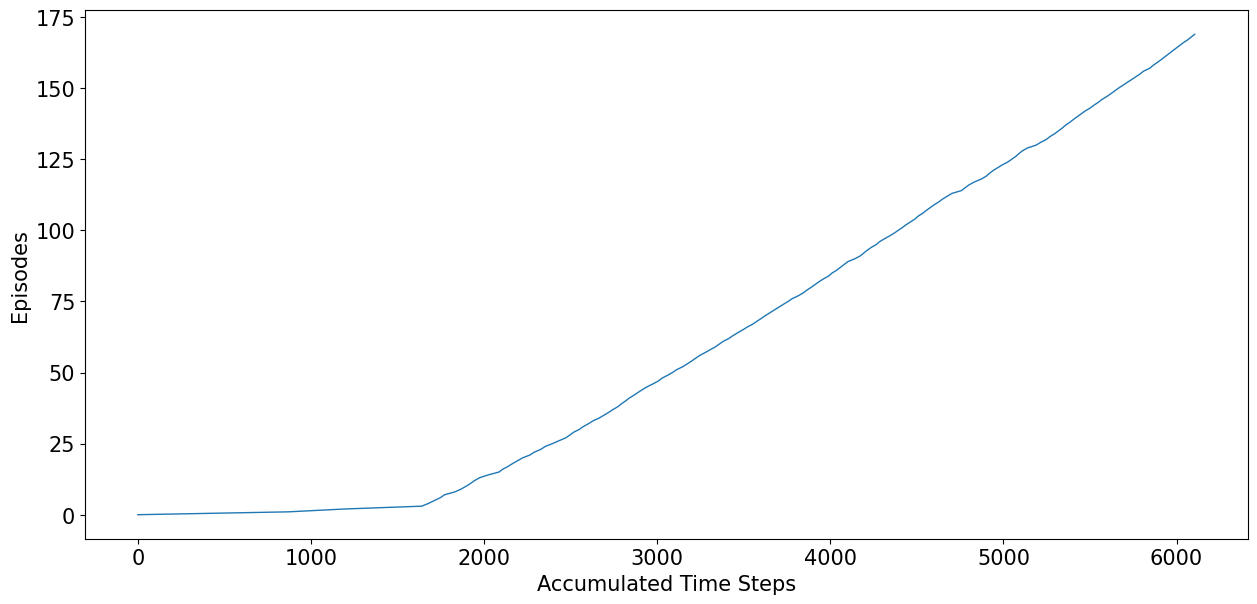

In [83]:
# plot the results
fig =plt.figure(figsize=(15,7))
axes = fig.subplots(1,1,squeeze=False)
ax = axes[0,0]
ax.plot([ sum(ts_per_episode[:i]) for i in range(k) ],range(k))
ax.set_ylabel('Episodes')
ax.set_xlabel('Accumulated Time Steps')
plt.show()